In [1]:
import pandas as pd

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
anime_data = pd.read_csv('anime.csv')
profile_data = pd.read_csv('profile.csv')

In [2]:
missing_values_train = train_data.isnull().sum()
missing_values_test = test_data.isnull().sum()
missing_values_anime = anime_data.isnull().sum()
missing_values_profile = profile_data.isnull().sum()

In [3]:
# Filling missing values for anime.csv
anime_data['synopsis'].fillna('', inplace=True)
anime_data['episodes'].fillna(anime_data['episodes'].median(), inplace=True)

# ranked は start_year=2020 または genre に Hentai が含まれている場合は全体の平均値、それ以外は max + 1 で埋める
anime_data['ranked'].fillna(anime_data[anime_data['start_year'] == 2020]['ranked'].mean(), inplace=True)
anime_data['ranked'].fillna(anime_data[anime_data['genre'].str.contains('Hentai')]['ranked'].mean(), inplace=True)
anime_data['ranked'].fillna(anime_data['ranked'].max() + 1, inplace=True)

# Filling missing values for profile.csv
profile_data['gender'].fillna('Unknown', inplace=True)
anime_data.isnull().sum(), profile_data.isnull().sum()

(id                  0
 title               0
 synopsis            0
 genre               0
 episodes            0
 members             0
 popularity          0
 ranked              0
 start_month       295
 start_day        1990
 start_year       1656
 end_month         766
 end_day          2404
 end_year         2114
 umap_vector_0       0
 umap_vector_1       0
 umap_vector_2       0
 umap_vector_3       0
 umap_vector_4       0
 umap_vector_5       0
 umap_vector_6       0
 umap_vector_7       0
 umap_vector_8       0
 umap_vector_9       0
 dtype: int64,
 user            0
 gender          0
 birthday    21037
 dtype: int64)

In [4]:
from datetime import datetime

# Converting birthday to age
def calculate_age(birthday):
    try:
        birth_date = datetime.strptime(birthday, '%b %d, %Y')
        return 2023 - birth_date.year
    except:
        try:
            birth_date = datetime.strptime(birthday, '%Y')
            return 2023 - birth_date.year
        except:
            try:
                birth_date = datetime.strptime(birthday, '%m, %Y')
                return 2023 - birth_date.year
            except:
                return None

profile_data['age'] = profile_data['birthday'].apply(calculate_age)

profile_data.drop('birthday', axis=1, inplace=True)


In [5]:
# 欠損値を平均値で埋める
profile_data['age'].fillna(profile_data['age'].mean(), inplace=True)

# 10以下、80以上の値を平均値で埋める
profile_data.loc[profile_data['age'] < 10, 'age'] = profile_data['age'].mean()
profile_data.loc[profile_data['age'] > 80, 'age'] = profile_data['age'].mean()

In [6]:
# start_yearが欠損値のデータのうち、start_monthが欠損値でないデータは start_year = start_month とする
anime_data.loc[anime_data['start_year'].isnull() & anime_data['start_month'].notnull(), 'start_year'] = anime_data['start_month']

# start_yearが欠損値のidを持っておく
missing_start_year_ids = anime_data.loc[anime_data['start_year'].isnull(), 'id']

anime_data_sorted = anime_data.sort_values('members', ascending=False)
# start_yearでソートしたものを作成
anime_data_sorted_by_start_year = anime_data.sort_values('start_year', ascending=False)

# start_yearの欠損値を、start_yearの大きさの順位が member の値の順位の数字 と同じ値の start_year で埋める
i = 0
for row in anime_data_sorted.itertuples():
    if pd.isna(row.start_year):
        anime_data.loc[anime_data['id'] == row.id, 'start_year'] = anime_data_sorted_by_start_year.iloc[i]['start_year']
    i += 1

# start_yearの欠損値を1940で埋める
anime_data['start_year'].fillna(1940, inplace=True)

In [7]:
# titleに Ⅱ, Ⅲ, Ⅳが含まれる、または、titleに "Season" が含まれる、 2nd, 3rd, 4th が含まれる、または、titleの末尾に 2, 3, 4 が含まれるものは 1 にする
season_symbols = ['Ⅱ', 'Ⅲ', 'Ⅳ', 'II', 'III', 'IV', '2nd', '3rd', '4th', ' Season', ' season']
anime_data['season'] = anime_data['title'].apply(lambda x: 1 if any(s in x for s in season_symbols) or any(x.endswith(s) for s in ['2', '3', '4']) else 0)

# titleに Lupin が含まれるものは 0 にする
anime_data['season'] = anime_data.apply(lambda x: 0 if 'Lupin' in x['title'] else x['season'], axis=1)


In [8]:
# genreをone-hotエンコーディング genre_〇〇 にする
import ast
anime_data['genre'] = anime_data['genre'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

genres = set()
for row in anime_data.itertuples():
    if isinstance(row.genre, list):
        for genre in row.genre:
            genres.add(genre)

for genre in genres:
    anime_data['genre_' + genre] = anime_data['genre'].apply(lambda x: 1 if isinstance(x, list) and genre in x else 0)

anime_data.head()


,id,title,synopsis,genre,episodes,members,popularity,ranked,start_month,start_day,...,genre_Fantasy,genre_Slice of Life,genre_Action,genre_Hentai,genre_Romance,genre_Horror,genre_Parody,genre_Shoujo Ai,genre_Samurai,genre_Sports
0,28891,Haikyuu!! Second Season,Following their participation at the Inter-Hig...,"[Comedy, Sports, Drama, School, Shounen]",25.0,489888,141,25.0,10.0,4.0,...,0,0,0,0,0,0,0,0,0,1
1,23273,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,"[Drama, Music, Romance, School, Shounen]",22.0,995473,28,24.0,10.0,10.0,...,0,0,0,0,1,0,0,0,0,0
2,34599,Made in Abyss,The Abyss—a gaping chasm stretching down into ...,"[Sci-Fi, Adventure, Mystery, Drama, Fantasy]",13.0,581663,98,23.0,7.0,7.0,...,1,0,0,0,0,0,0,0,0,0
3,5114,Fullmetal Alchemist: Brotherhood,"""In order for something to be obtained, someth...","[Action, Military, Adventure, Comedy, Drama, M...",64.0,1615084,4,1.0,4.0,5.0,...,1,0,1,0,0,0,0,0,0,0
4,31758,Kizumonogatari III: Reiketsu-hen,After helping revive the legendary vampire Kis...,"[Action, Mystery, Supernatural, Vampire]",1.0,214621,502,22.0,1.0,6.0,...,0,0,1,0,0,0,0,0,0,0


In [9]:
# 重複データの削除
anime_data.drop_duplicates(subset=['id'], inplace=True)

In [10]:
# train_data(anime_id) と anime_data(id) を結合 left outer join
train_data_merged = pd.merge(train_data, anime_data, left_on='anime_id', right_on='id', how='left')
test_data_merged = pd.merge(test_data, anime_data, left_on='anime_id', right_on='id', how='left')

# start_day, start_month, end_month, end_day, end_year を削除
train_data_merged.drop(columns=['start_day', 'start_month', 'end_month', 'end_day', 'end_year'], inplace=True)
test_data_merged.drop(columns=['start_day', 'start_month', 'end_month', 'end_day', 'end_year'], inplace=True)

In [11]:
# scoreが10より大きいものを10にする
train_data_merged.loc[train_data_merged['score'] > 10, 'score'] = 10

# scoreが1より小さいものを1にする
train_data_merged.loc[train_data_merged['score'] < 1, 'score'] = 1


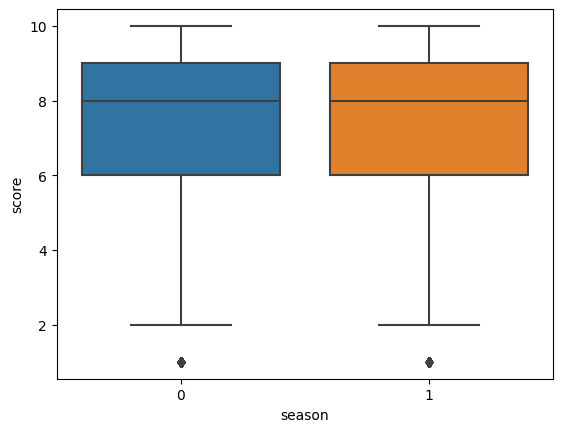

In [12]:
# season ごとに score の分布を可視化
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='season', y='score', data=train_data_merged)
plt.show()


In [13]:
# train_data(user) と profile_data(user) を結合
train_data_merged = pd.merge(train_data_merged, profile_data, left_on='user', right_on='user', how='left')
test_data_merged = pd.merge(test_data_merged, profile_data, left_on='user', right_on='user', how='left')


In [14]:
# その行以外のuserがつけたscoreの数をカウントして、その値をカラムにする userscore_1 ~ userscore_10
# 先にmapを作る
from collections import defaultdict

user_score_map = defaultdict(lambda: defaultdict(int))
for row in train_data_merged.itertuples():
    user_score_map[row.user][row.score] += 1

# mapを使ってカラムを作る
for i in range(1, 11):
    train_data_merged['userscore_' + str(i)] = train_data_merged.apply(lambda x: user_score_map[x['user']][i] if i != x['score'] else user_score_map[x['user']][i] - 1, axis=1)
    test_data_merged['userscore_' + str(i)] = test_data_merged.apply(lambda x: user_score_map[x['user']][i], axis=1)


# # scoreの平均値を計算
# score_mean = train_data_merged['score'].mean()

# # その行以外のuserがつけたscoreの平均値をカラムにする userscore_mean
# # 先にmapを作る
# user_score_mean_map = defaultdict(lambda: defaultdict(int))
# for row in train_data_merged.itertuples():
#     user_score_mean_map[row.user]['score'] += row.score
#     user_score_mean_map[row.user]['count'] += 1

# # mapを使ってカラムを作る
# train_data_merged['userscore_mean'] = train_data_merged.apply(lambda x: (user_score_mean_map[x['user']]['score'] - x['score']) / (user_score_mean_map[x['user']]['count'] - 1 if user_score_mean_map[x['user']]['count'] > 1 else score_mean), axis=1)
# test_data_merged['userscore_mean'] = test_data_merged.apply(lambda x: user_score_mean_map[x['user']]['score'] / user_score_mean_map[x['user']]['count'] if user_score_mean_map[x['user']]['count'] > 0 else score_mean, axis=1)


# # score_1 ~ score_10 カラムを 行ごとに正規化
# columns_to_normalize = [f'userscore_{i}' for i in range(1, 11)]
# train_data_merged[columns_to_normalize] = train_data_merged[columns_to_normalize].apply(lambda x: x / x.sum() if x.sum() != 0 else x, axis=1)
# test_data_merged[columns_to_normalize] = test_data_merged[columns_to_normalize].apply(lambda x: x / x.sum() if x.sum() != 0 else x, axis=1)

In [15]:
# その行以外のuser がつけた score の平均値を取って、userscore という名前のカラムに追加
# train_data_merged['userscore'] = train_data_merged.groupby('user')['score'].transform(lambda x: (x.sum() - x) / (x.count() - 1) if x.count() > 1 else None)
# test_data_merged['userscore'] = train_data_merged.groupby('user')['score'].transform(lambda x: x.mean() if x.count() > 0 else None)

In [16]:
# anime ごとに score の平均値を取って、animescore という名前のカラムに追加
train_data_merged['animescore'] = train_data_merged.groupby('anime_id')['score'].transform(lambda x: (x.sum() - x) / (x.count() - 1) if x.count() > 1 else None)
test_data_merged['animescore'] = train_data_merged.groupby('anime_id')['score'].transform(lambda x: x.mean() if x.count() > 0 else None)

# animescore が欠損値のものは、平均値で埋める
train_data_merged['animescore'].fillna(train_data_merged['score'].mean(), inplace=True)
test_data_merged['animescore'].fillna(train_data_merged['score'].mean(), inplace=True)

In [17]:
# userscoreの欠損値を、animescoreと全scoreの平均のの相乗平均で埋める
# av_score = train_data_merged['score'].mean()
# train_data_merged['userscore'].fillna((train_data_merged['animescore'] * av_score) ** 0.5, inplace=True)
# test_data_merged['userscore'].fillna((test_data_merged['animescore'] * av_score) ** 0.5, inplace=True)

In [18]:
# text_len を追加
train_data_merged['text_len'] = train_data_merged['text'].apply(lambda x: len(x.replace(' ', '').replace('\n', '')))

# その行以外のuserごとの平均 text_len を追加
# train_data_merged['user_text_len'] = train_data_merged.groupby('user')['text_len'].transform(lambda x: (x.sum() - x) / (x.count() - 1) if x.count() > 1 else None)
# test_data_merged['user_text_len'] = train_data_merged.groupby('user')['text_len'].transform(lambda x: x.mean())

# user_text_lenが0のものについては全体の平均で埋める
# av_text_len = train_data_merged['text_len'].mean()
# train_data_merged['user_text_len'].fillna(av_text_len, inplace=True)
# test_data_merged['user_text_len'].fillna(av_text_len, inplace=True)


In [19]:
from sklearn.preprocessing import OneHotEncoder

# gender の Non-Binary を Unknown にする
train_data_merged = train_data_merged.replace('Non-Binary', 'Unknown')
test_data_merged = test_data_merged.replace('Non-Binary', 'Unknown')

# genderをOne-Hotエンコーディング
gender_encoder = OneHotEncoder()
gender_one_hot = gender_encoder.fit_transform(train_data_merged[['gender']]).toarray()  # type: ignore
gender_labels = gender_encoder.get_feature_names_out(['gender'])
for i, label in enumerate(gender_labels):
    train_data_merged[label] = gender_one_hot[:, i]

gender_one_hot_test = gender_encoder.transform(test_data_merged[['gender']]).toarray()  # type: ignore
for i, label in enumerate(gender_labels):
    test_data_merged[label] = gender_one_hot_test[:, i]


In [20]:
# gender_Femaleの合計
train_data_merged['gender_Male'].sum(), train_data_merged['gender_Female'].sum(), train_data_merged['gender_Unknown'].sum()

(54876.0, 19108.0, 31365.0)

genderを二値分類で推測しようのコーナー

Accuracy: 0.860178970917226
AUC: 0.649166409602064
Accuracy: 0.849112426035503
AUC: 0.6243534043872353
Accuracy: 0.851063829787234
AUC: 0.6245613038059245
Accuracy: 0.8512396694214877
AUC: 0.6220641292866007
Accuracy: 0.8426724137931034
AUC: 0.6304515423541146
Accuracy: 0.8517382413087935
AUC: 0.6322272215973003
Accuracy: 0.8353783231083844
AUC: 0.6353131285927097
Accuracy: 0.8827292110874201
AUC: 0.6404105571847507
Accuracy: 0.8359375
AUC: 0.6192128028966988
Accuracy: 0.8551111111111112
AUC: 0.6300006278252135
Mean Accuracy: 0.8515161696570261


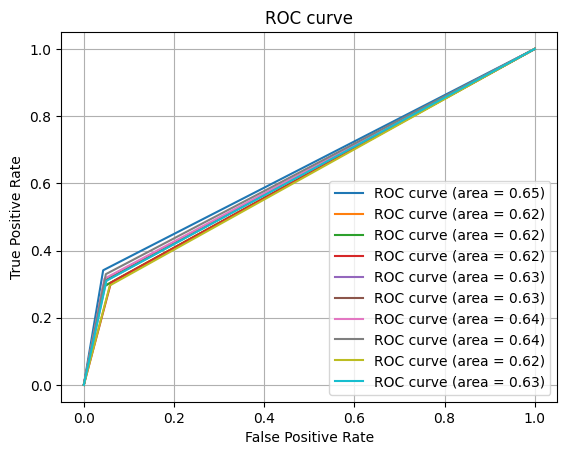

In [21]:
import warnings 
warnings.simplefilter('ignore')

# genderが Male or Female のもののみを残す
train_valid = train_data_merged[(train_data_merged['gender_Male'] == 1) | train_data_merged['gender_Female'] == 1]
train_invalid = train_data_merged[train_data_merged['gender_Unknown'] == 1]

genre_columns = [col for col in train_valid.columns if 'genre_' in col]

# genre_{任意のジャンル}カラムにscoreを掛ける
for genre in genre_columns:
    train_valid[genre] *= train_valid['score']
    train_invalid[genre] *= train_invalid['score']

# userごとにジャンルカラムを合計し、1に正規化
train_valid_grouped = train_valid.groupby('user')[genre_columns].sum()
train_valid_grouped = train_valid_grouped.div(train_valid_grouped.sum(axis=1), axis=0)
train_invalid_grouped = train_invalid.groupby('user')[genre_columns].sum()
train_invalid_grouped = train_invalid_grouped.div(train_invalid_grouped.sum(axis=1), axis=0)

# gender, userカラムを追加
train_valid_grouped['gender'] = train_valid.groupby('user')['gender'].first()
train_valid_grouped['user'] = train_valid_grouped.index
train_invalid_grouped['user'] = train_invalid_grouped.index

# Male 0 Female 1
train_valid_grouped['gender'] = train_valid_grouped['gender'].map({'Male': 0, 'Female': 1})
train_valid_grouped = train_valid_grouped.reset_index(drop=True)
train_invalid_grouped = train_invalid_grouped.reset_index(drop=True)

x_train = train_valid_grouped.drop(columns=['gender', 'user'])
y_train = train_valid_grouped['gender']

x_test = train_invalid_grouped.drop(columns=['user'])

import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, roc_curve, auc
import numpy as np

# パラメータの設定
params = {
    'objective': 'binary',
    'metric': 'auc',
    'verbose': -1,
    'boosting': 'gbdt',
    'early_stopping_round': 20,
    'n_estimators': 10000, 
    'learning_rate': 0.05,
}
# 10分割のクロスバリデーション
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# 各分割での評価スコアを保存
scores = []

for train_index, val_index in kf.split(x_train):
    x_train_fold, x_val_fold = x_train.iloc[train_index], x_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    bst = lgb.LGBMRegressor(**params)
    bst.fit(x_train_fold, y_train_fold, eval_set=[(x_train_fold, y_train_fold), (x_val_fold, y_val_fold)])

    # 予測
    y_prod = bst.predict(x_val_fold)
    y_pred = np.round(y_prod)  # type: ignore

    # 評価
    y_pred_tmp = np.where(y_prod <= 0.2, 0, np.where(y_prod >= 0.8, 1, 2))  # type: ignore
    index_to_remove = np.where(y_pred_tmp == 2)
    y_pred_tmp = np.delete(y_pred_tmp, index_to_remove)
    y_val_fold_tmp = np.delete(y_val_fold, index_to_remove)

    acc = accuracy_score(y_val_fold_tmp, y_pred_tmp)  # type: ignore
    scores.append(acc)
    print(f'Accuracy: {acc}')

    fpr, tpr, thresholds = roc_curve(y_val_fold, y_pred)
    aucval = auc(fpr, tpr)
    print(f'AUC: {aucval}')

    # ROC曲線をプロット
    plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%aucval)
    plt.legend()
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)

# 全体の平均スコア
mean_score = np.mean(scores)
print(f'Mean Accuracy: {mean_score}')

In [22]:
# important_features の上位10個を表示
importance = pd.DataFrame(bst.feature_importances_, index=x_train.columns, columns=['importance'])
importance.sort_values('importance', ascending=False).head()

,importance
genre_Comedy,401
genre_Romance,355
genre_Action,347
genre_Drama,311
genre_Fantasy,289


In [23]:
y_pred_test = bst.predict(x_test)
# 0.3以下のものを0、0.7以上のものを1、それ以外を2にする
y_pred_test = np.where(y_pred_test < 0.4, 0, np.where(y_pred_test >= 0.6, 1, 2))  # type: ignore

train_invalid_grouped['gender'] = y_pred_test
# userとgenderの対応を示したmapを作成
user_gender_map = pd.Series(train_invalid_grouped['gender'].values, index=train_invalid_grouped['user']).to_dict()

gender_map = {
    0: 'Male', 1: 'Female', 2: 'Unknown'
}

# gender_Unknownが1で、user_gender_mapに存在するuserに対して操作を行う
for idx, row in train_data_merged[train_data_merged['gender_Unknown'] == 1].iterrows():
    user_value = row['user']
    gender_value = user_gender_map.get(user_value)
    if gender_value is not None:
        train_data_merged.loc[idx, 'gender_Male'] = 1 if gender_value == 0 else 0  # type: ignore
        train_data_merged.loc[idx, 'gender_Female'] = 1 if gender_value == 1 else 0  # type: ignore
        train_data_merged.loc[idx, 'gender_Unknown'] = 1 if gender_value == 2 else 0  # type: ignore
        train_data_merged.loc[idx, 'gender'] = gender_map[gender_value]  # type: ignore

for idx, row in test_data_merged[test_data_merged['gender_Unknown'] == 1].iterrows():
    user_value = row['user']
    gender_value = user_gender_map.get(user_value)
    if gender_value is not None:
        test_data_merged.loc[idx, 'gender_Male'] = 1 if gender_value == 0 else 0  # type: ignore
        test_data_merged.loc[idx, 'gender_Female'] = 1 if gender_value == 1 else 0  # type: ignore
        test_data_merged.loc[idx, 'gender_Unknown'] = 1 if gender_value == 2 else 0  # type: ignore
        test_data_merged.loc[idx, 'gender'] = gender_map[gender_value]  # type: ignore


In [24]:
# gender_Femaleの合計
train_data_merged['gender_Male'].sum(), train_data_merged['gender_Female'].sum(), train_data_merged['gender_Unknown'].sum()

(81126.0, 21539.0, 2684.0)

In [25]:
# gender_ から始まるカラムと genre_ から始まるカラムを掛け合わせる
for gender_col in [col for col in train_data_merged.columns if col.startswith('gender_')]:
    for genre_col in [col for col in train_data_merged.columns if col.startswith('genre_')]:
        gender = gender_col.split('_')[1]
        genre = genre_col.split('_')[1]
        new_col_name = f'gen_{genre}_{gender}'
        train_data_merged[new_col_name] = train_data_merged[gender_col] * train_data_merged[genre_col]

for gender_col in [col for col in test_data_merged.columns if col.startswith('gender_')]:
    for genre_col in [col for col in test_data_merged.columns if col.startswith('genre_')]:
        gender = gender_col.split('_')[1]
        genre = genre_col.split('_')[1]
        new_col_name = f'gen_{genre}_{gender}'
        test_data_merged[new_col_name] = test_data_merged[gender_col] * test_data_merged[genre_col]

In [26]:
# gen_ から始まるカラムで合計が500以下のものを削除
for col in [col for col in train_data_merged.columns if col.startswith('gen_')]:
    if train_data_merged[col].sum() <= 500:
        train_data_merged.drop(columns=[col], inplace=True)

In [27]:
# train_data_merged のカラムを確認
print(train_data_merged.columns.tolist())

['user', 'anime_id', 'text', 'score', 'id', 'title', 'synopsis', 'genre', 'episodes', 'members', 'popularity', 'ranked', 'start_year', 'umap_vector_0', 'umap_vector_1', 'umap_vector_2', 'umap_vector_3', 'umap_vector_4', 'umap_vector_5', 'umap_vector_6', 'umap_vector_7', 'umap_vector_8', 'umap_vector_9', 'season', 'genre_Space', 'genre_Game', 'genre_Demons', 'genre_Magic', 'genre_Mecha', 'genre_Adventure', 'genre_Police', 'genre_Shoujo', 'genre_Dementia', 'genre_Yaoi', 'genre_Sci-Fi', 'genre_Shounen', 'genre_Music', 'genre_Cars', 'genre_Super Power', 'genre_Martial Arts', 'genre_Military', 'genre_Vampire', 'genre_Psychological', 'genre_Mystery', 'genre_School', 'genre_Harem', 'genre_Drama', 'genre_Shounen Ai', 'genre_Historical', 'genre_Supernatural', 'genre_Kids', 'genre_Ecchi', 'genre_Thriller', 'genre_Yuri', 'genre_Seinen', 'genre_Josei', 'genre_Comedy', 'genre_Fantasy', 'genre_Slice of Life', 'genre_Action', 'genre_Hentai', 'genre_Romance', 'genre_Horror', 'genre_Parody', 'genre_Sho

In [28]:
# weight カラムを作成し、1で初期化
train_data_merged['weight'] = 1

In [29]:
# aggregate features
cat_cols = ['user']
agg_cols = ['episodes', 'members', 'ranked', 'start_year']
agg_types = ['mean', 'std', 'max', 'min', 'sum']

for cat_col in cat_cols:
    for agg_col in agg_cols:
        for agg_type in agg_types:
            if cat_col != agg_col:
                new_col_name = 'agg_' + cat_col + '_' + agg_col + '_' + agg_type
                temp = train_data_merged[[cat_col, agg_col]]
                temp = temp.groupby([cat_col])[agg_col].agg([agg_type]).reset_index().rename(columns={agg_type: new_col_name})
                temp.index = list(temp[cat_col])  # type: ignore
                temp = temp[new_col_name].to_dict()
                train_data_merged[new_col_name] = train_data_merged[cat_col].map(temp)

                new_col_name = 'agg_' + cat_col + '_' + agg_col + '_' + agg_type
                temp = train_data_merged[[cat_col, agg_col]]
                temp = temp.groupby([cat_col])[agg_col].agg([agg_type]).reset_index().rename(columns={agg_type: new_col_name})
                temp.index = list(temp[cat_col])  # type: ignore
                temp = temp[new_col_name].to_dict()
                test_data_merged[new_col_name] = test_data_merged[cat_col].map(temp)

In [30]:
# ['episodes', 'members', 'ranked', 'start_year', 'season', 'genre_*', 'gender', 'age'] カラムを特徴量として摘出する
correct_features = ['episodes', 'members', 'ranked', 'start_year', 'age']
correct_features.extend([col for col in train_data_merged.columns if col.startswith('gen_') and 'Unknown' not in col])
correct_features.extend([col for col in train_data_merged.columns if col.startswith('userscore_')])
# correct_features.extend([col for col in train_data_merged.columns if col.startswith('agg_')])
# correct_features.extend([col for col in train_data_merged.columns if col.startswith('umap_vector_')])

x_train = train_data_merged[correct_features + ['weight']]
x_test = test_data_merged[correct_features]

# score を正解データとして摘出する
y_train = train_data_merged['score']

Mean Squared Error for fold: 3.7049966093488997


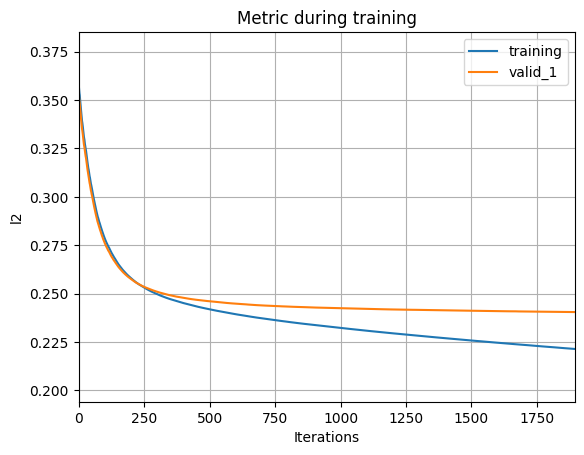

Mean Squared Error for fold: 3.8004702371741548


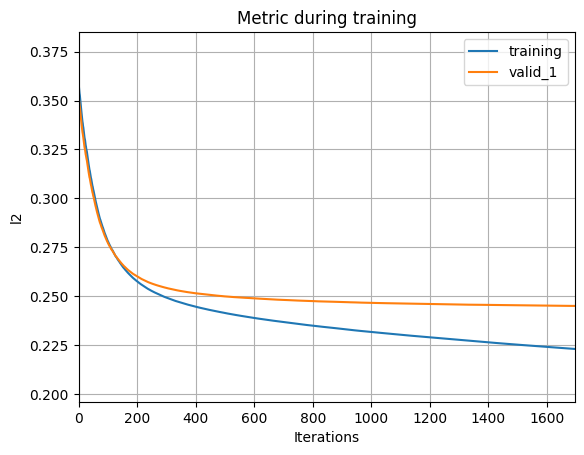

Mean Squared Error for fold: 3.703149831179123


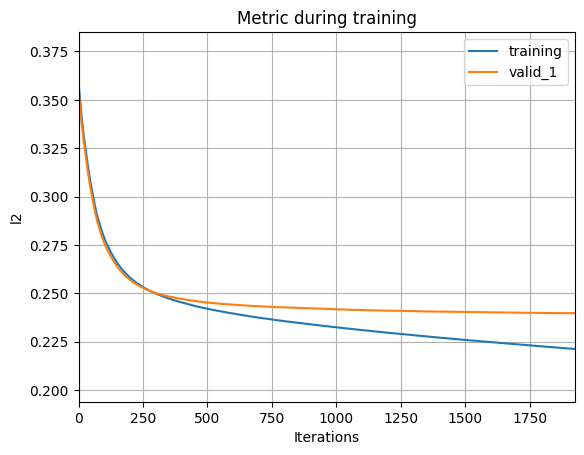

Mean Squared Error for fold: 3.8716367258353057


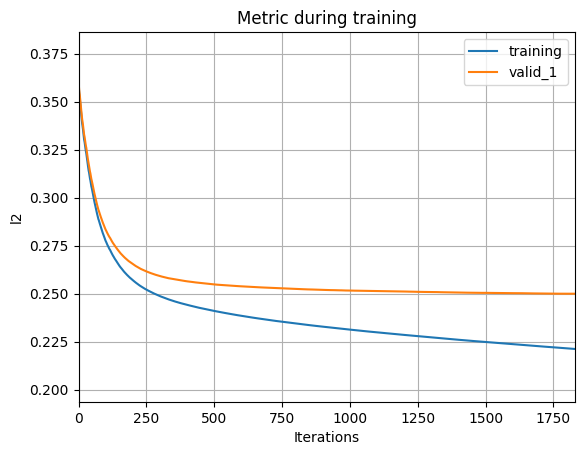

Mean Squared Error for fold: 3.9489609540211137


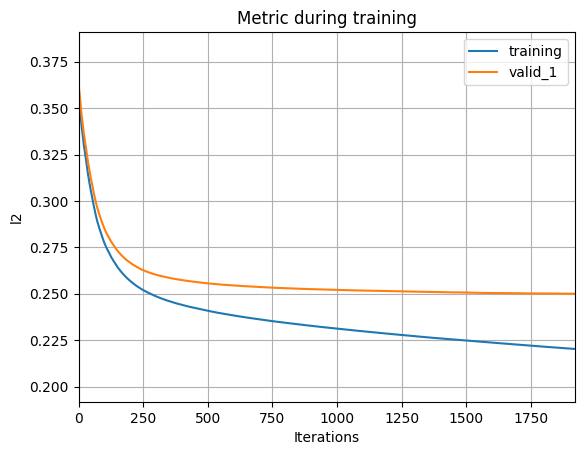

Mean Squared Error for fold: 3.8060398113061


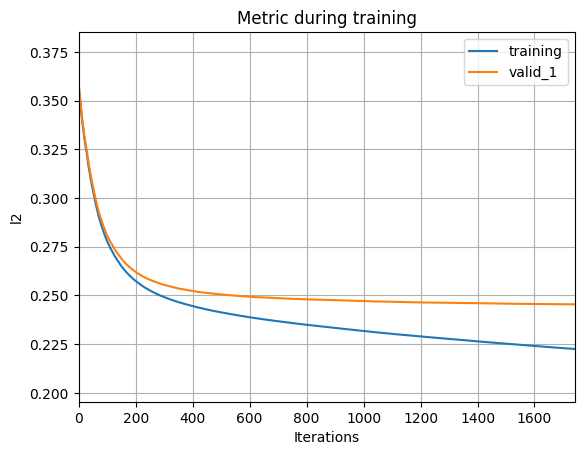

Mean Squared Error for fold: 3.8032268050795057


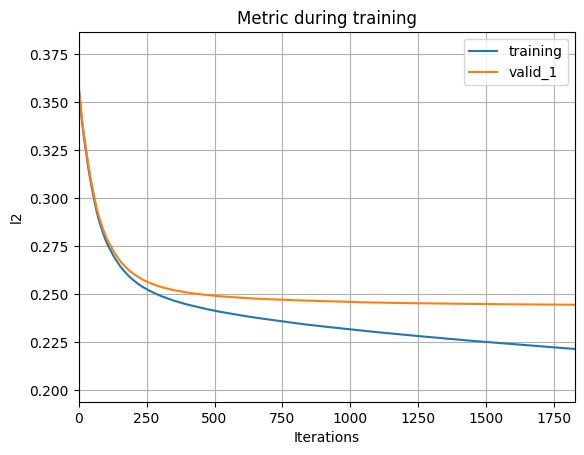

Mean Squared Error for fold: 3.8257999726331855


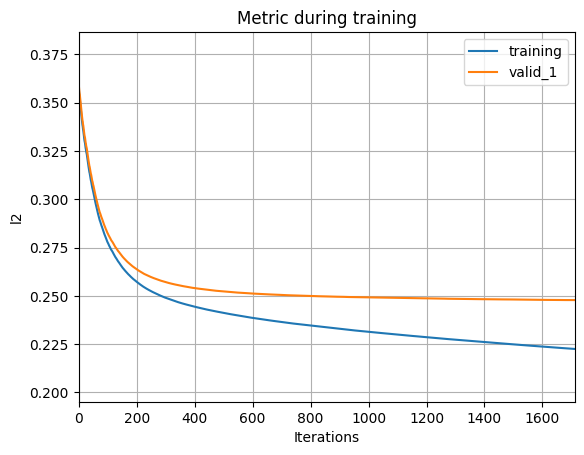

Mean Squared Error for fold: 3.8487026516824288


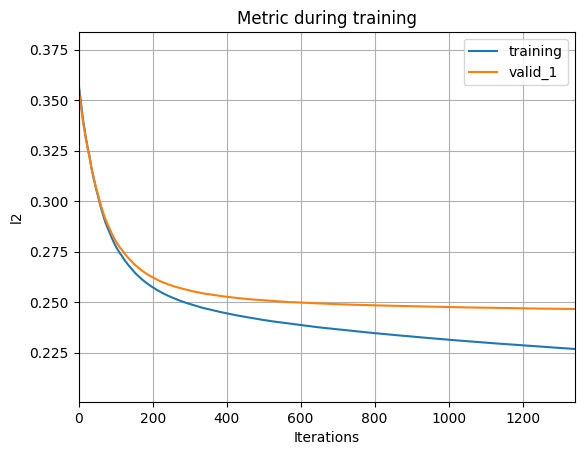

Mean Squared Error for fold: 3.813992147743217


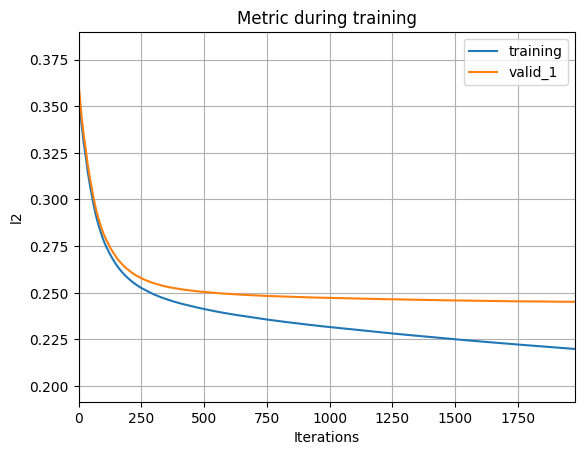

Mean Squared Error for 5-folds CV: 3.8126975746003033


In [31]:
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np

# パラメータの設定
params = {
    'objective': 'regression',
    'metric': 'mse',
    'verbose': -1,
    'early_stopping_round': 20,
    'n_estimators': 10000, 
    'boosting_type': 'gbdt',  # default = 'gbdt'
    'num_leaves': 63,         # default = 31,
    'learning_rate': 0.01,    # default = 0.1
    'feature_fraction': 0.8,  # default = 1.0
    'bagging_freq': 1,        # default = 0
    'bagging_fraction': 0.8,  # default = 1.0
    'random_state': 0,        # default = None
    'max_depth': 9,
}
# 10分割のクロスバリデーション
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# 各分割での評価スコアを保存
scores = []

for train_index, val_index in kf.split(x_train):
    x_train_fold, x_val_fold = x_train.iloc[train_index], x_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    sample_weight = x_train_fold['weight']
    x_train_fold = x_train_fold.drop(columns=['weight'])
    x_val_fold = x_val_fold.drop(columns=['weight'])

    # 11から引いた上で平方根をとる
    y_train_fold = np.sqrt(11 - y_train_fold)  # type: ignore
    y_val_fold = np.sqrt(11 - y_val_fold)  # type: ignore

    bst = lgb.LGBMRegressor(**params)
    bst.fit(x_train_fold, y_train_fold, eval_set=[(x_train_fold, y_train_fold), (x_val_fold, y_val_fold)], sample_weight=sample_weight)  # type: ignore

    # 予測
    y_pred = bst.predict(x_val_fold)

    # (11から引いた上で平方根をとる)の逆変換
    y_pred = 11 - np.square(y_pred)  # type: ignore
    y_val_fold = 11 - np.square(y_val_fold)  # type: ignore

    # 評価
    mse = mean_squared_error(y_val_fold, y_pred)  # type: ignore
    scores.append(mse)
    print(f'Mean Squared Error for fold: {mse}')

    lgb.plot_metric(bst)
    plt.show()

# 全体の平均スコア
mean_score = np.mean(scores)
print(f'Mean Squared Error for 5-folds CV: {mean_score}')


In [32]:
# important_features の上位10個を表示
importance = pd.DataFrame(bst.feature_importances_, index=x_train.drop(columns=['weight']).columns, columns=['importance'])
importance.sort_values('importance', ascending=False).head(30)

,importance
members,14222
ranked,14200
age,10046
start_year,9533
userscore_10,7201
episodes,6660
userscore_9,5468
userscore_8,5134
userscore_7,4512
userscore_6,3464


In [33]:
y_pred_test = bst.predict(x_test)
# (11から引いた上で平方根をとる)の逆変換
y_pred_test = 11 - np.square(y_pred_test)  # type: ignore

# sample_submission.csv を読み込む
sample_submission = pd.read_csv('sample_submission.csv')

# predicted_scores を sample_submission の score に代入
sample_submission['score'] = y_pred_test


<Axes: >

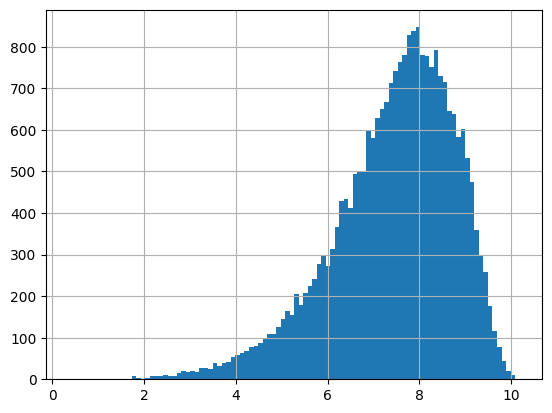

In [34]:
# sample_submission のスコア分布を確認
sample_submission['score'].hist(bins=100)

In [35]:
# sample_submission のスコアで10より大きいものを10にする
sample_submission.loc[sample_submission['score'] > 10, 'score'] = 10

# sample_submission を出力
sample_submission.to_csv('submission.csv', index=False)